In [2]:
import numpy as np
import pandas as pd
from tensorflow import keras
from matplotlib import pyplot as plt

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offset1, offset2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offset1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offset2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

In [4]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50], series[:, 50:]
print(X_new.shape)

(1, 50, 1)


In [8]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_absolute_error(Y_true[:,-1], Y_pred[:,-1])

In [9]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [10]:
n_steps = 50
horizon = 25 # One entire period
series = generate_time_series(10000, n_steps + horizon)

print(series.shape)

# (7000 time series, 50 steps each)
X_train, y_train = series[:7000, :n_steps], series[:7000, -horizon, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -horizon, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -horizon, 0]


Y = np.empty((10000, n_steps, horizon))
for step_ahead in range(1, horizon + 1):
    Y[:,:, step_ahead - 1] = series[:,step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

(10000, 75, 1)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)


In [6]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(horizon))
])

model_ln = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(horizon))
])

model_lstm = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(horizon))
])

2021-12-09 22:26:57.340736: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-09 22:26:57.341555: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
model_gru = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(horizon))
])

In [8]:
model.summary()
model_ln.summary()
model_lstm.summary()
model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 20)          440       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 time_distributed (TimeDistr  (None, None, 25)         525       
 ibuted)                                                         
                                                                 
Total params: 1,785
Trainable params: 1,785
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn (RNN)                   (None, None, 20)          480       
                                

In [9]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
epochs = 7
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
model_ln.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
model_lstm.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
model_gru.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

In [10]:
history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid))

Epoch 1/7
219/219 [==============================] - 30s 127ms/step - loss: 0.0759 - last_time_step_mse: 0.2051 - val_loss: 0.0678 - val_last_time_step_mse: 0.1892
Epoch 2/7
219/219 [==============================] - 30s 139ms/step - loss: 0.0644 - last_time_step_mse: 0.1817 - val_loss: 0.0674 - val_last_time_step_mse: 0.1817
Epoch 3/7
219/219 [==============================] - 21s 97ms/step - loss: 0.0579 - last_time_step_mse: 0.1650 - val_loss: 0.0554 - val_last_time_step_mse: 0.1503
Epoch 4/7
219/219 [==============================] - 27s 125ms/step - loss: 0.0538 - last_time_step_mse: 0.1544 - val_loss: 0.0513 - val_last_time_step_mse: 0.1395
Epoch 5/7
219/219 [==============================] - 26s 118ms/step - loss: 0.0516 - last_time_step_mse: 0.1482 - val_loss: 0.0515 - val_last_time_step_mse: 0.1511
Epoch 6/7
219/219 [==============================] - 27s 125ms/step - loss: 0.0484 - last_time_step_mse: 0.1388 - val_loss: 0.0463 - val_last_time_step_mse: 0.1321
Epoch 7/7
219/219

In [11]:
history_ln = model_ln.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid))

Epoch 1/7
219/219 [==============================] - 69s 298ms/step - loss: 0.0854 - last_time_step_mse: 0.2220 - val_loss: 0.0747 - val_last_time_step_mse: 0.2089
Epoch 2/7
219/219 [==============================] - 55s 250ms/step - loss: 0.0678 - last_time_step_mse: 0.1933 - val_loss: 0.0658 - val_last_time_step_mse: 0.1826
Epoch 3/7
219/219 [==============================] - 55s 251ms/step - loss: 0.0619 - last_time_step_mse: 0.1794 - val_loss: 0.0603 - val_last_time_step_mse: 0.1718
Epoch 4/7
219/219 [==============================] - 53s 240ms/step - loss: 0.0579 - last_time_step_mse: 0.1662 - val_loss: 0.0548 - val_last_time_step_mse: 0.1531
Epoch 5/7
219/219 [==============================] - 59s 269ms/step - loss: 0.0514 - last_time_step_mse: 0.1468 - val_loss: 0.0503 - val_last_time_step_mse: 0.1429
Epoch 6/7
219/219 [==============================] - 50s 230ms/step - loss: 0.0488 - last_time_step_mse: 0.1399 - val_loss: 0.0503 - val_last_time_step_mse: 0.1463
Epoch 7/7
219/21

In [12]:
history_lstm = model_lstm.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid))

Epoch 1/7
219/219 [==============================] - 45s 178ms/step - loss: 0.0668 - last_time_step_mse: 0.1811 - val_loss: 0.0474 - val_last_time_step_mse: 0.1356
Epoch 2/7
219/219 [==============================] - 38s 173ms/step - loss: 0.0439 - last_time_step_mse: 0.1274 - val_loss: 0.0420 - val_last_time_step_mse: 0.1217
Epoch 3/7
219/219 [==============================] - 35s 161ms/step - loss: 0.0387 - last_time_step_mse: 0.1129 - val_loss: 0.0373 - val_last_time_step_mse: 0.1038
Epoch 4/7
219/219 [==============================] - 38s 175ms/step - loss: 0.0337 - last_time_step_mse: 0.0920 - val_loss: 0.0320 - val_last_time_step_mse: 0.0809
Epoch 5/7
219/219 [==============================] - 42s 191ms/step - loss: 0.0304 - last_time_step_mse: 0.0769 - val_loss: 0.0295 - val_last_time_step_mse: 0.0739
Epoch 6/7
219/219 [==============================] - 35s 162ms/step - loss: 0.0289 - last_time_step_mse: 0.0714 - val_loss: 0.0287 - val_last_time_step_mse: 0.0688
Epoch 7/7
219/21

In [13]:
history_gru = model_gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid))

Epoch 1/7
219/219 [==============================] - 49s 209ms/step - loss: 0.0677 - last_time_step_mse: 0.1882 - val_loss: 0.0514 - val_last_time_step_mse: 0.1460
Epoch 2/7
219/219 [==============================] - 53s 242ms/step - loss: 0.0438 - last_time_step_mse: 0.1269 - val_loss: 0.0410 - val_last_time_step_mse: 0.1147
Epoch 3/7
219/219 [==============================] - 50s 227ms/step - loss: 0.0379 - last_time_step_mse: 0.1057 - val_loss: 0.0370 - val_last_time_step_mse: 0.0987
Epoch 4/7
219/219 [==============================] - 54s 248ms/step - loss: 0.0338 - last_time_step_mse: 0.0890 - val_loss: 0.0337 - val_last_time_step_mse: 0.0883
Epoch 5/7
219/219 [==============================] - 48s 219ms/step - loss: 0.0317 - last_time_step_mse: 0.0816 - val_loss: 0.0314 - val_last_time_step_mse: 0.0817
Epoch 6/7
219/219 [==============================] - 51s 234ms/step - loss: 0.0304 - last_time_step_mse: 0.0762 - val_loss: 0.0308 - val_last_time_step_mse: 0.0759
Epoch 7/7
219/21

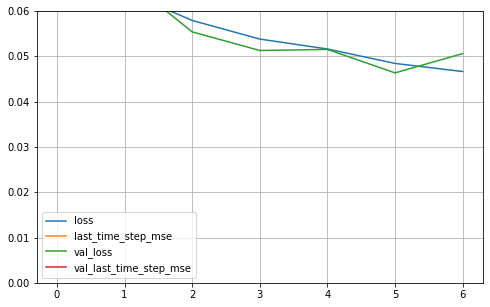

In [14]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(-0,0.06)
plt.show()

In [15]:
Y_pred = model.predict(X_test)
Y_pred_ln = model_ln.predict(X_test)
Y_pred_lstm = model_lstm.predict(X_test)
Y_pred_gru = model_gru.predict(X_test)

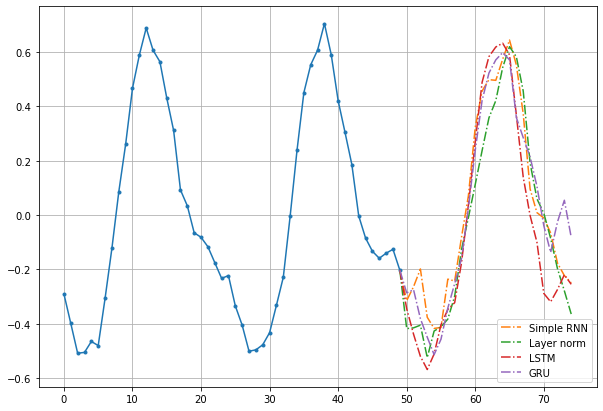

In [24]:
sequence = np.concatenate((X_test[222].flatten(), Y_pred[222,-horizon:,-1].flatten()))
sequence_ln = np.concatenate((X_test[222].flatten(), Y_pred_ln[222,-horizon:,-1].flatten()))
sequence_lstm = np.concatenate((X_test[222].flatten(), Y_pred_lstm[222,-horizon:,-1].flatten()))
sequence_gru = np.concatenate((X_test[222].flatten(), Y_pred_gru[222,-horizon:,-1].flatten()))


x = np.arange(n_steps+horizon)
plt.figure(figsize=(10,7))
plt.plot(x[:n_steps], sequence[:n_steps], '.-')
plt.plot(x[n_steps-1:], sequence[n_steps-1:], '-.', label="Simple RNN")
plt.plot(x[n_steps-1:], sequence_ln[n_steps-1:], '-.', label="Layer norm")
plt.plot(x[n_steps-1:], sequence_lstm[n_steps-1:], '-.', label="LSTM")
plt.plot(x[n_steps-1:], sequence_gru[n_steps-1:], '-.', label="GRU")
plt.legend()
plt.grid()
plt.show()